<a href="https://colab.research.google.com/github/yasinsoylu1997/64-64-UnderSampler/blob/main/ResNet50_models_64_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras


     |████████████████████████████████| 992 kB 5.2 MB/s 


In [ ]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [ ]:
X = []
y = []
image_size = 64
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:19<00:00, 67.47it/s] 


In [ ]:
from imblearn.under_sampling import RandomUnderSampler 

reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomUnderSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
new_X = oversampled_X.reshape(-1,64,64,3)
oversampled_y

array(['COVID', 'COVID', 'COVID', ..., 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia'], dtype='<U15')

In [ ]:
train_images, test_images,train_labels, test_labels = train_test_split(new_X , oversampled_y , test_size=0.25, random_state=42,shuffle=True)

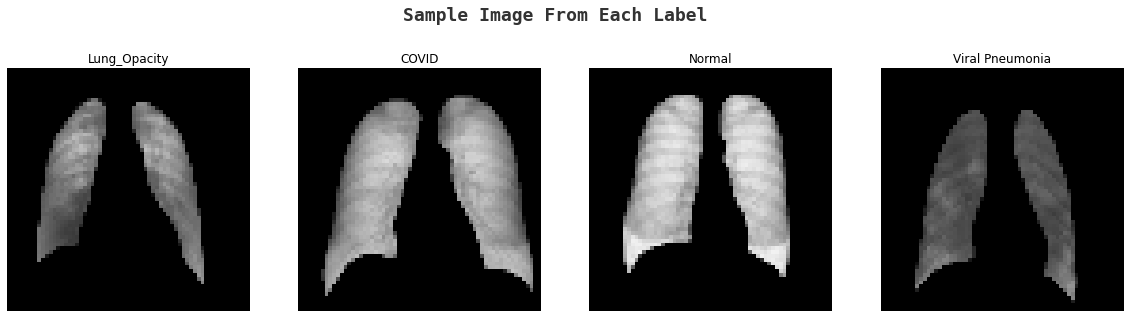

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y[j]==i:
            ax[k].imshow(X[j])
            ax[k].set_title(y[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

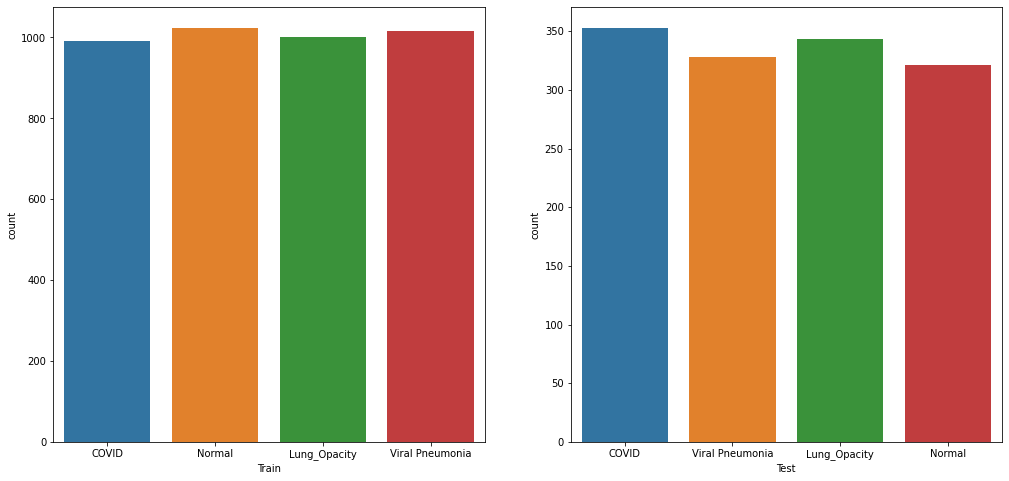

In [ ]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [ ]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [ ]:
#Load model wothout classifier/fully connected layers
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in ResNet50_model.layers:
	layer.trainable = False
    
ResNet50_model.summary()  #Trainable parameters will be 0

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                          

In [ ]:
#Now, let us use features from convolutional network for RF
feature_extractor=ResNet50_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_model= features #This is our X input for model

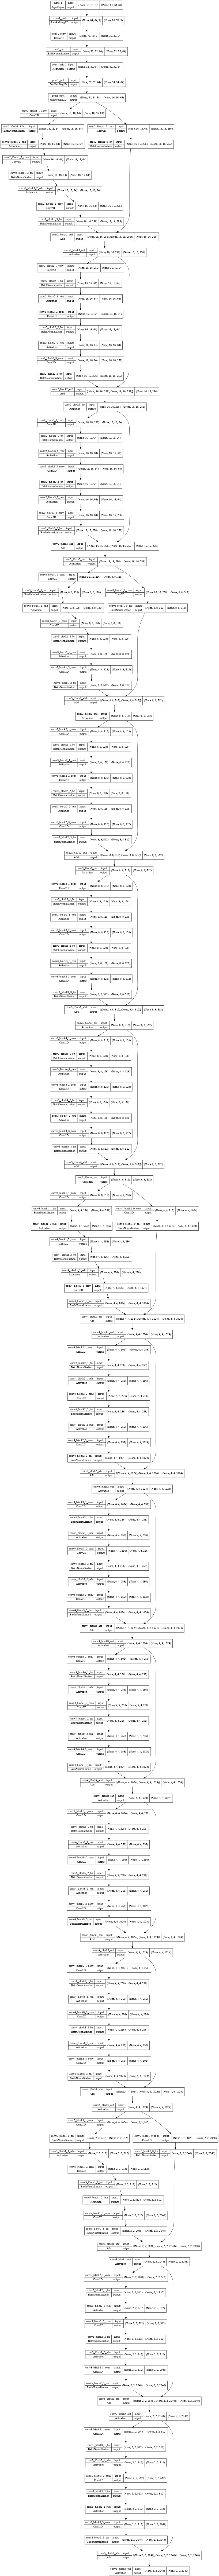

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(ResNet50_model, to_file='model_plot_ResNet50_224.png', show_shapes=True, show_layer_names=True,dpi=50)

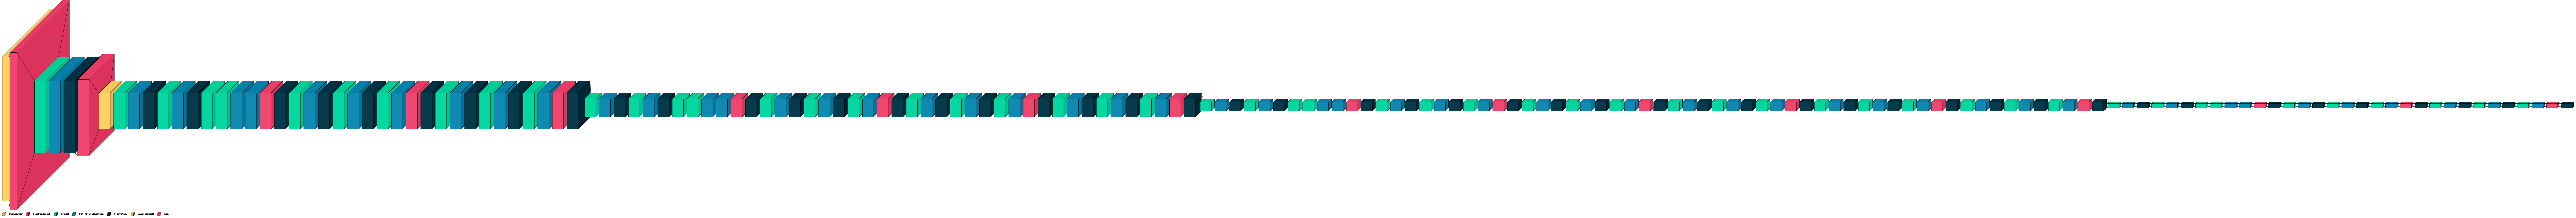

<Figure size 144x144 with 0 Axes>

In [ ]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(ResNet50_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

# knn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [ ]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = knn_model.predict(X_test_features)

In [ ]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.5026022304832714
MSE: 0.820817843866171
RMSE: 0.9059899800031846
R2 Square 0.3492488804861439
Accuracy 0.6401486988847583
__________________________________


In [ ]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, prediction) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.502602,0.820818,0.90599,0.349249,0.640149


In [ ]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53       353
           1       0.57      0.56      0.56       343
           2       0.59      0.63      0.61       321
           3       0.88      0.86      0.87       328

    accuracy                           0.64      1345
   macro avg       0.64      0.64      0.64      1345
weighted avg       0.64      0.64      0.64      1345



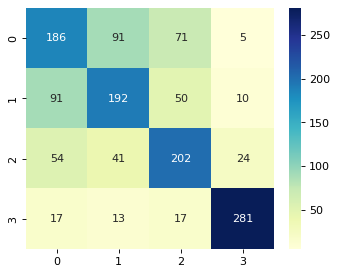

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [ ]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = cart_model.predict(X_test_features)

In [ ]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.6282527881040892
MSE: 1.0594795539033457
RMSE: 1.0293102320988292
R2 Square 0.16003591910575643
Accuracy 0.562081784386617
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.502602,0.820818,0.90599,0.349249,0.640149
1,DecisionTreeClassifier,0.628253,1.059480,1.02931,0.160036,0.562082


In [ ]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.52      0.43      0.47       353
           1       0.47      0.50      0.48       343
           2       0.48      0.53      0.51       321
           3       0.79      0.80      0.79       328

    accuracy                           0.56      1345
   macro avg       0.57      0.57      0.56      1345
weighted avg       0.56      0.56      0.56      1345



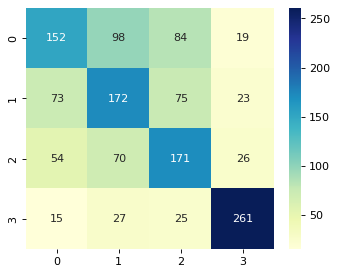

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = lr_model.predict(X_test_features)

In [ ]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.475092936802974
MSE: 0.80817843866171
RMSE: 0.8989874518933565
R2 Square 0.3592695046090928
Accuracy 0.6765799256505576
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.502602,0.820818,0.905990,0.349249,0.640149
1,DecisionTreeClassifier,0.628253,1.059480,1.029310,0.160036,0.562082
2,LogisticRegression,0.475093,0.808178,0.898987,0.359270,0.676580


In [ ]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.57      0.50      0.53       353
           1       0.63      0.70      0.66       343
           2       0.61      0.63      0.62       321
           3       0.90      0.90      0.90       328

    accuracy                           0.68      1345
   macro avg       0.68      0.68      0.68      1345
weighted avg       0.67      0.68      0.67      1345



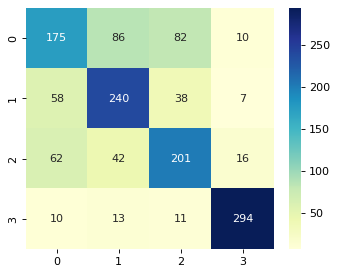

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [ ]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = LGBM_model.predict(X_test_features)

In [ ]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.38438661710037175
MSE: 0.5925650557620817
RMSE: 0.7697824730156447
R2 Square 0.530209563177044
Accuracy 0.7137546468401487
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.502602,0.820818,0.905990,0.349249,0.640149
1,DecisionTreeClassifier,0.628253,1.059480,1.029310,0.160036,0.562082
2,LogisticRegression,0.475093,0.808178,0.898987,0.359270,0.676580
3,LGBMClassifier,0.384387,0.592565,0.769782,0.530210,0.713755


In [ ]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.65      0.58      0.61       353
           1       0.64      0.68      0.66       343
           2       0.65      0.69      0.67       321
           3       0.93      0.91      0.92       328

    accuracy                           0.71      1345
   macro avg       0.72      0.72      0.72      1345
weighted avg       0.72      0.71      0.71      1345



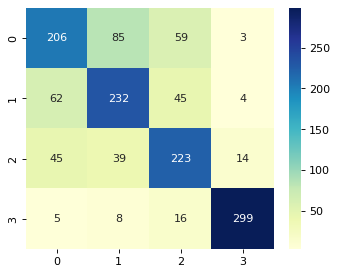

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [ ]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = rf_model.predict(X_test_features)

In [ ]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.4884758364312268
MSE: 0.803717472118959
RMSE: 0.8965029124988714
R2 Square 0.3628061954760159
Accuracy 0.6527881040892193
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.502602,0.820818,0.905990,0.349249,0.640149
1,DecisionTreeClassifier,0.628253,1.059480,1.029310,0.160036,0.562082
2,LogisticRegression,0.475093,0.808178,0.898987,0.359270,0.676580
3,LGBMClassifier,0.384387,0.592565,0.769782,0.530210,0.713755
4,RandomForestClassifier,0.488476,0.803717,0.896503,0.362806,0.652788


In [ ]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.58      0.50      0.54       353
           1       0.58      0.62      0.60       343
           2       0.58      0.62      0.60       321
           3       0.86      0.88      0.87       328

    accuracy                           0.65      1345
   macro avg       0.65      0.66      0.65      1345
weighted avg       0.65      0.65      0.65      1345



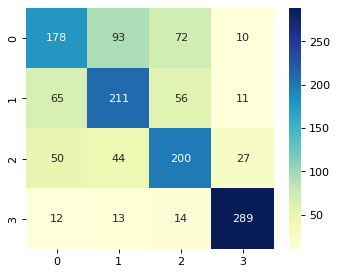

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [ ]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GB_model.predict(X_test_features)

In [ ]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.9092936802973978
MSE: 1.5308550185873606
RMSE: 1.237277260191652
R2 Square -0.2136744158324544
Accuracy 0.36951672862453533
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.502602,0.820818,0.905990,0.349249,0.640149
1,DecisionTreeClassifier,0.628253,1.059480,1.029310,0.160036,0.562082
2,LogisticRegression,0.475093,0.808178,0.898987,0.359270,0.676580
3,LGBMClassifier,0.384387,0.592565,0.769782,0.530210,0.713755
4,RandomForestClassifier,0.488476,0.803717,0.896503,0.362806,0.652788
5,GaussianNB,0.909294,1.530855,1.237277,-0.213674,0.369517


In [ ]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.39      0.15      0.21       353
           1       0.51      0.13      0.21       343
           2       0.30      0.94      0.45       321
           3       0.92      0.30      0.45       328

    accuracy                           0.37      1345
   macro avg       0.53      0.38      0.33      1345
weighted avg       0.53      0.37      0.33      1345



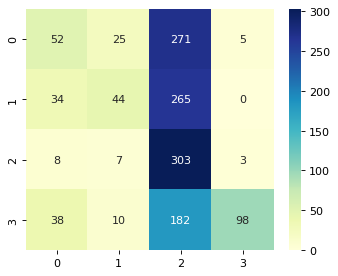

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [ ]:
X_test_feature =ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = SGD_model.predict(X_test_features)

In [ ]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.49814126394052044
MSE: 0.6364312267657992
RMSE: 0.7977663986191692
R2 Square 0.49543210298563334
Accuracy 0.5635687732342007
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.502602,0.820818,0.905990,0.349249,0.640149
1,DecisionTreeClassifier,0.628253,1.059480,1.029310,0.160036,0.562082
2,LogisticRegression,0.475093,0.808178,0.898987,0.359270,0.676580
3,LGBMClassifier,0.384387,0.592565,0.769782,0.530210,0.713755
4,RandomForestClassifier,0.488476,0.803717,0.896503,0.362806,0.652788
5,GaussianNB,0.909294,1.530855,1.237277,-0.213674,0.369517
6,SGDClassifier,0.498141,0.636431,0.797766,0.495432,0.563569


In [ ]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       1.00      0.05      0.09       353
           1       0.40      0.97      0.56       343
           2       0.69      0.35      0.46       321
           3       0.90      0.91      0.90       328

    accuracy                           0.56      1345
   macro avg       0.75      0.57      0.50      1345
weighted avg       0.75      0.56      0.50      1345



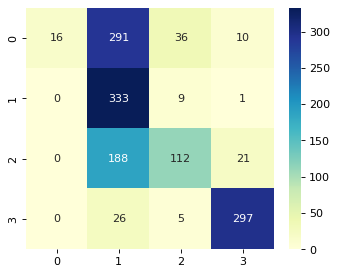

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SVC

In [ ]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [ ]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svm_model.predict(X_test_features)

In [ ]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.4096654275092937
MSE: 0.6936802973977695
RMSE: 0.8328747189090142
R2 Square 0.4500445701934531
Accuracy 0.7189591078066915
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.502602,0.820818,0.905990,0.349249,0.640149
1,DecisionTreeClassifier,0.628253,1.059480,1.029310,0.160036,0.562082
2,LogisticRegression,0.475093,0.808178,0.898987,0.359270,0.676580
3,LGBMClassifier,0.384387,0.592565,0.769782,0.530210,0.713755
4,RandomForestClassifier,0.488476,0.803717,0.896503,0.362806,0.652788
5,GaussianNB,0.909294,1.530855,1.237277,-0.213674,0.369517
6,SGDClassifier,0.498141,0.636431,0.797766,0.495432,0.563569
7,SVC,0.409665,0.693680,0.832875,0.450045,0.718959


In [ ]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.62      0.57      0.60       353
           1       0.70      0.71      0.70       343
           2       0.64      0.72      0.67       321
           3       0.93      0.89      0.91       328

    accuracy                           0.72      1345
   macro avg       0.72      0.72      0.72      1345
weighted avg       0.72      0.72      0.72      1345



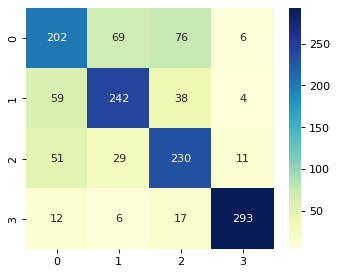

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [ ]:
modeller = [rf_model,GB_model,LGBM_model,SGD_model,lr_model,cart_model,svm_model,knn_model]


In [ ]:
sonuc = []
from sklearn.metrics import accuracy_score

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy_ResNet50"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_features)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy_ResNet50"])
    sonuclar = sonuclar.append(sonuc)
    

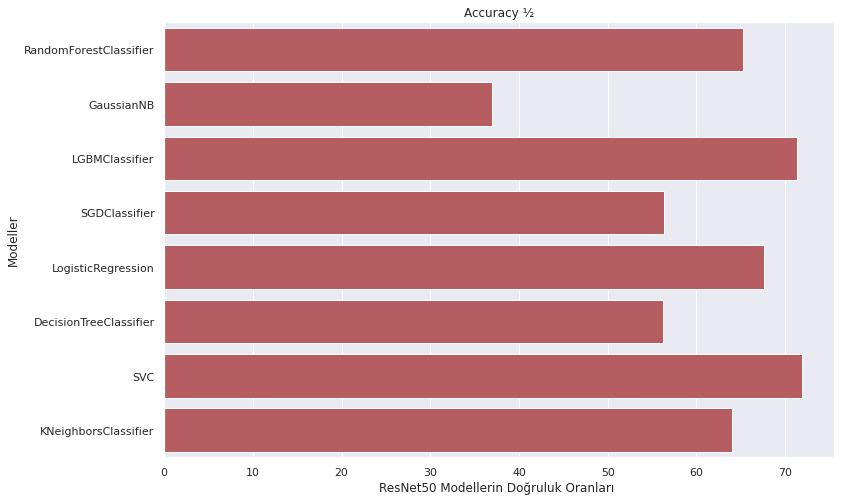

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x= 'Accuracy_ResNet50', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('ResNet50 Modellerin Doğruluk Oranları ')
plt.title('Accuracy ½'); 

In [ ]:
best_acc=sonuclar.sort_values(by=['Accuracy_ResNet50'], ascending=False)
en_iyi_model_my_model=best_acc[:1]
en_iyi_model_my_model

,Modeller,Accuracy_ResNet50
0,SVC,71.895911


In [ ]:
results_df


,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.502602,0.820818,0.905990,0.349249,0.640149
1,DecisionTreeClassifier,0.628253,1.059480,1.029310,0.160036,0.562082
2,LogisticRegression,0.475093,0.808178,0.898987,0.359270,0.676580
3,LGBMClassifier,0.384387,0.592565,0.769782,0.530210,0.713755
4,RandomForestClassifier,0.488476,0.803717,0.896503,0.362806,0.652788
5,GaussianNB,0.909294,1.530855,1.237277,-0.213674,0.369517
6,SGDClassifier,0.498141,0.636431,0.797766,0.495432,0.563569
7,SVC,0.409665,0.693680,0.832875,0.450045,0.718959


In [ ]:
from google.colab import files

results_df.to_csv('output_resnet50_224.csv', encoding = 'utf-8-sig') 
files.download('output_resnet50_224.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>